In [1]:
#path_main_summarized_table = "../datasets/2023-01-01_benchmark_processed_data/2023-01-27_FullTableAurocFiltered.tsv"
#path_crossprot_summarized_table = "../results/2023-01-01/00_processed/crossProt/aurocs.tsv.gz"
path_main_summarized_table = "../results/2023-05-24/00_processed/main/aurocs.tsv.gz"
path_crossprot_summarized_table = "../results/2023-05-24/00_processed/crossProt/aurocs.tsv.gz"

path_config_viz = "../config/visualization.yaml"
path_output_dir = "./"
export_plots = False


# Forewords

Cross protocols type application of models

# Imports


In [2]:
import copy
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/lambertmoy/projects/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Config

In [3]:

with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


# Load

In [4]:
full_summary_table = pd.read_csv(
    path_main_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

In [5]:
full_summary_table_prot = pd.read_csv(
    path_crossprot_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

full_summary_table_prot["RBP-name"] = (
    full_summary_table_prot["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 0]
    .values
)
full_summary_table_prot["CT"] = (
    full_summary_table_prot["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 1]
    .values
)

# Format

In [6]:
ENCODE_RBP_LIST =  [
    'EIF3D_HepG2',
    'EIF3G_K562',
    'EWSR1_K562',
    'FUS_HepG2',
    'FXR1_K562',
    'FXR2_HepG2',
    'IGF2BP1_HepG2',
    'IGF2BP2_K562',
    'IGF2BP3_HepG2',
    'LIN28B_HepG2',
    'PUM2_K562',
    'QKI_HepG2',
    'SSB_HepG2',
    'TAF15_HepG2',
    'TARDBP_K562',
    'UPF1_HepG2',
    'XPO5_HepG2',
]

PARCLIP_RBP_LIST = [
    'EIF3D_HEK293_PARCLIP',
    'EIF3G_HEK293_PARCLIP',
    'EWSR1_HEK293_PARCLIP',
    'FUS_HEK293_PARCLIP',
    'FXR1_HEK293_PARCLIP',
    'FXR2_HEK293_PARCLIP',
    'IGF2BP1_HEK293_PARCLIP',
    'IGF2BP2_HEK293_PARCLIP',
    'IGF2BP3_HEK293_PARCLIP',
    'LIN28B_HEK293_PARCLIP',
    'PUM2_HEK293_PARCLIP',
    'QKI_HEK293_PARCLIP',
    'SSB_HEK293_PARCLIP',
    'TAF15_HEK293_PARCLIP',
    'TARDBP_HEK293_PARCLIP',
    'UPF1_HEK293_PARCLIP',
    'XPO5_HEK293_PARCLIP',
]

In [7]:
full_summary_table['dataset'].unique()

array(['ENCODE', 'Mukherjee-PAR-CLIP', 'iONMF'], dtype=object)

In [8]:
#NOTE: most of the code has the same logic as the cross-celltype evaluations.
# Hence I copied the code from the associated notebook, and modified
# column names and logic so as to get the cross-protocol comparison.
# But variable names are still the same as in the cross-celltype notebook...
#TODO: update variable names.


full_summarized_table_ct = full_summary_table_prot

In [9]:
full_summarized_table_ct.shape

(68, 33)

## Cross-evaluations

In [10]:
full_summarized_table_ct['RBP-name'] = full_summarized_table_ct['RBP_dataset'].str.split('_', expand=True).iloc[:,0].values
full_summarized_table_ct['CT'] = full_summarized_table_ct['RBP_dataset'].str.split('_', expand=True).iloc[:,1].values

display(full_summarized_table_ct.head(3))


,unique_id,auroc,arch,dataset,RBP_dataset,fold,model_negativeset,sample_negset,dataset.1,RBP_dataset.1,...,pc_max.pos,pc_avg.neg,pc_avg.pos,cm.tn,cm.fp,cm.fn,cm.tp,cm.thresh,RBP-name,CT
0,0,0.879017,Pysster,ENCODE,EIF3D_HepG2,0,negative-1,negative-1,ENCODE,EIF3D_HepG2,...,0.999462,0.19091,0.720504,0.413043,0.086957,0.110672,0.389328,0.455707,EIF3D,HepG2
1,1,0.780078,Pysster,ENCODE,EIF3D_HepG2,0,negative-2,negative-2,ENCODE,EIF3D_HepG2,...,0.978767,0.33807,0.592985,0.328063,0.171937,0.108696,0.391304,0.465528,EIF3D,HepG2
2,2,0.854961,Pysster,ENCODE,EIF3G_K562,0,negative-1,negative-1,ENCODE,EIF3G_K562,...,0.999839,0.17362,0.643258,0.410180,0.089820,0.137725,0.362275,0.408439,EIF3G,K562


In [11]:
t1_ct_n1 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t1_ct_n2 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_ct_n1 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_ct_n2 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

In [12]:
cross_ct_merged_n1 = pd.merge(
                        t1_ct_n1.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_ct_n1.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


cross_ct_merged_n2 = pd.merge(
                        t1_ct_n2.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_ct_n2.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


## Self evaluations

In [13]:
cross_ct_merged_n1.head(3)

,arch,RBP-name,RBP_dataset.EC,auroc.EC,RBP_dataset.PC,auroc.PC
0,Pysster,EIF3D,EIF3D_HepG2,0.879017,EIF3D_HEK293_PARCLIP,0.771495
1,Pysster,EIF3G,EIF3G_K562,0.854961,EIF3G_HEK293_PARCLIP,0.888164
2,Pysster,EWSR1,EWSR1_K562,0.382707,EWSR1_HEK293_PARCLIP,0.652605


In [14]:
tmp = full_summary_table.loc[
        lambda df: (df['arch'].isin(full_summarized_table_ct['arch'].unique())) & \
                        (df['RBP_dataset'].isin(cross_ct_merged_n1['RBP_dataset.EC'].values) | \
                        df['RBP_dataset'].isin(cross_ct_merged_n1['RBP_dataset.PC'])),
        :].copy()

In [15]:
tmp['RBP-name'] = tmp['RBP_dataset'].str.split('_',expand=True).iloc[:,0].values
tmp['CT'] = tmp['RBP_dataset'].str.split('_',expand=True).iloc[:,1].values   

In [16]:
t1_o_n1 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t1_o_n2 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_o_n1 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_o_n2 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

In [17]:
cross_o_merged_n1 = pd.merge(
                        t1_o_n1.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_o_n1.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


cross_o_merged_n2 = pd.merge(
                        t1_o_n2.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_o_n2.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


## Self vs cross

In [18]:
encode_selfcross_merged_n1 = pd.merge(
                        t1_ct_n1.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t1_o_n1.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


encode_selfcross_merged_n2 = pd.merge(
                        t1_ct_n2.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t1_o_n2.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


parclip_selfcross_merged_n1 = pd.merge(
                        t2_ct_n1.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t2_o_n1.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


parclip_selfcross_merged_n2 = pd.merge(
                        t2_ct_n2.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t2_o_n2.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


# Plot

## Scatter

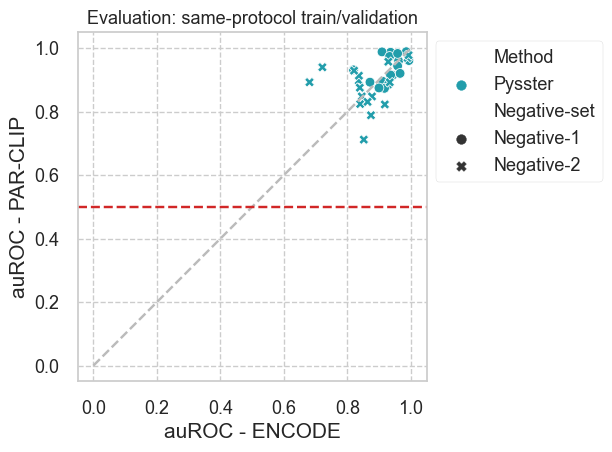

In [19]:
panel_name = 'kl'

if export_plots:
    savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
else:
    savefig_file = None

fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES['i']])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=pd.concat([
            cross_o_merged_n1.assign(negativeset='Negative-1'),
            cross_o_merged_n2.assign(negativeset='Negative-2'),]
            ).rename(columns={'arch':'Method','negativeset':'Negative-set'}),
    x='auroc.EC',
    y='auroc.PC',
    hue='Method',
    style='Negative-set',
    palette=arch_colors,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')
ax1.axhline(0.5, linestyle='--', color='#D12727')

ax1.set_aspect('equal')

#ax1.set_xlim([0.55,1.05])
#ax1.set_ylim([0.55,1.05])

ax1.set_xlabel('auROC - ENCODE')
ax1.set_ylabel('auROC - PAR-CLIP')

ax1.set_title("Evaluation: same-protocol train/validation")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)


if savefig_file:
    my_savefig(savefig_file)
    

plt.show()

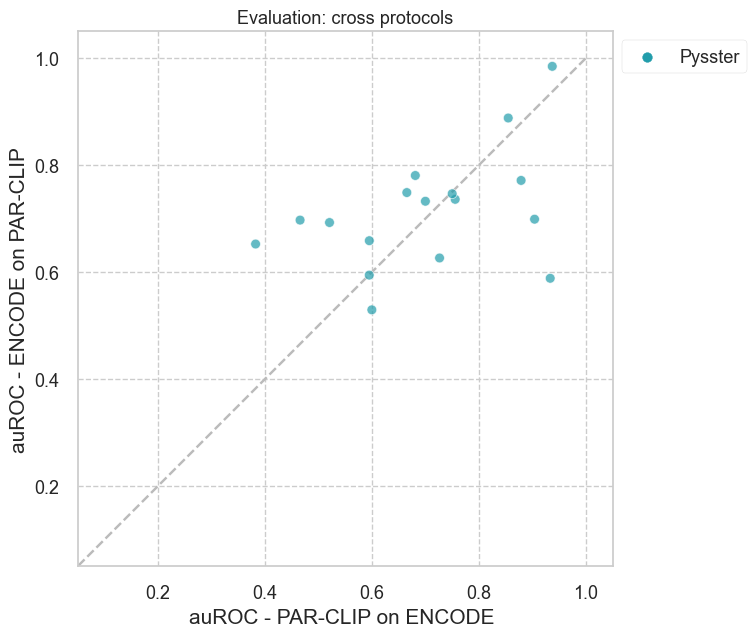

In [20]:
panel_name = 'i'

if export_plots:
    savefig_file = f"plots/fig3/panel_j.{{EXT}}"
else:
    savefig_file = None


fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES[panel_name]])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=cross_ct_merged_n1,
    x='auroc.EC',
    y='auroc.PC',
    hue='arch',
    palette=arch_colors,
    zorder=10,
    alpha=0.7,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')

ax1.set_aspect('equal')

ax1.set_xlim([0.05,1.05])
ax1.set_ylim([0.05,1.05])

ax1.set_xlabel('auROC - PAR-CLIP on ENCODE ')
ax1.set_ylabel('auROC - ENCODE on PAR-CLIP')

ax1.set_title("Evaluation: cross protocols")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()


if savefig_file:
    my_savefig(savefig_file)

plt.show()

## Scatter 2 : self vs cross

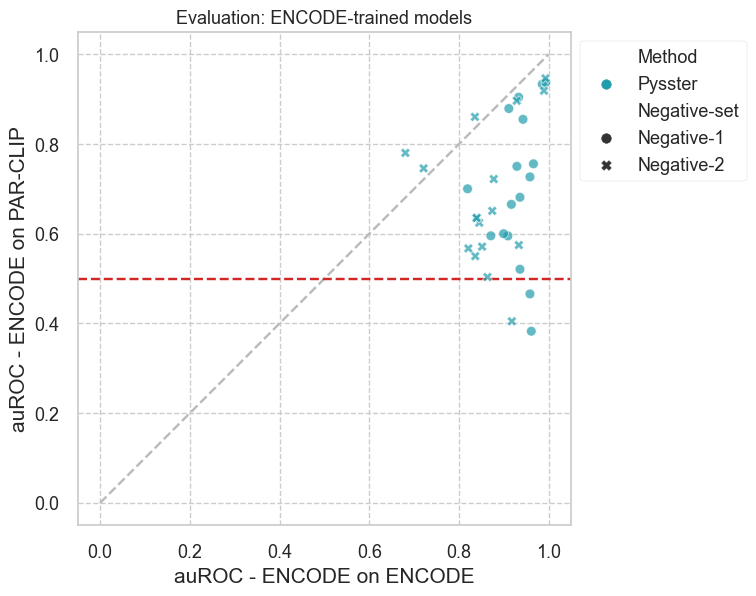

In [21]:
panel_name = 'k'

if export_plots:
    savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
else:
    savefig_file = None

fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES['i']])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=pd.concat([
            encode_selfcross_merged_n1.assign(negativeset='Negative-1'),
            encode_selfcross_merged_n2.assign(negativeset='Negative-2'),]
            ).rename(columns={'arch':'Method','negativeset':'Negative-set'}),
    x='auroc.self',
    y='auroc.cross',
    hue='Method',
    palette=arch_colors,
    style='Negative-set',
    zorder=10,
    alpha=0.7,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')
ax1.axhline(0.5, linestyle='--', color='#D12727')

ax1.set_aspect('equal')

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel('auROC - ENCODE on ENCODE')
ax1.set_ylabel('auROC - ENCODE on PAR-CLIP')


ax1.set_title("Evaluation: ENCODE-trained models")


fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()


if savefig_file:
    print("Saving")
    my_savefig(savefig_file)
    

plt.show()

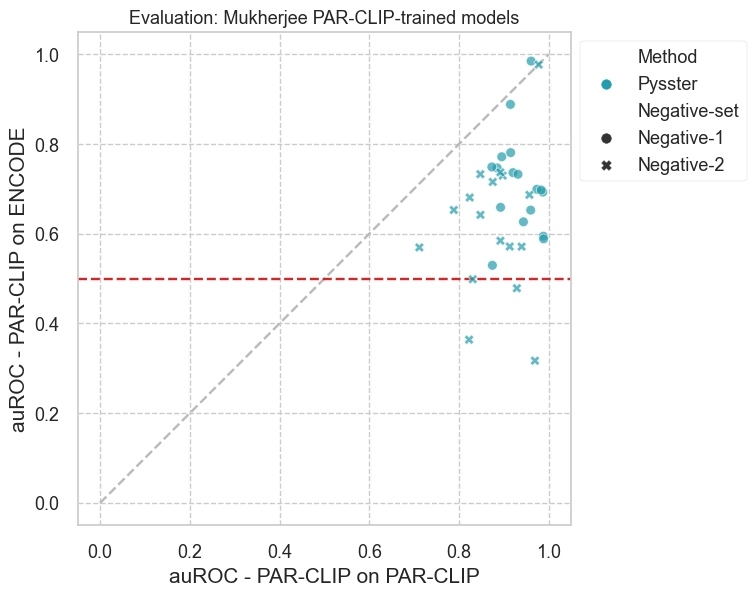

In [22]:
panel_name = 'l'

if export_plots:
    savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
else:
    savefig_file = None

fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES['i']])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=pd.concat([
            parclip_selfcross_merged_n1.assign(negativeset='Negative-1'),
            parclip_selfcross_merged_n2.assign(negativeset='Negative-2'),]
            ).rename(columns={'arch':'Method','negativeset':'Negative-set'}),
    x='auroc.self',
    y='auroc.cross',
    hue='Method',
    palette=arch_colors,
    style='Negative-set',
    zorder=10,
    alpha=0.7,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')
ax1.axhline(0.5, linestyle='--', color='#D12727')

ax1.set_aspect('equal')

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel('auROC - PAR-CLIP on PAR-CLIP')
ax1.set_ylabel('auROC - PAR-CLIP on ENCODE')

ax1.set_title("Evaluation: Mukherjee PAR-CLIP-trained models")


#ax1.set_title("Evaluation: matched cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()

if savefig_file:
    print("Saving")
    my_savefig(savefig_file)
    

plt.show()